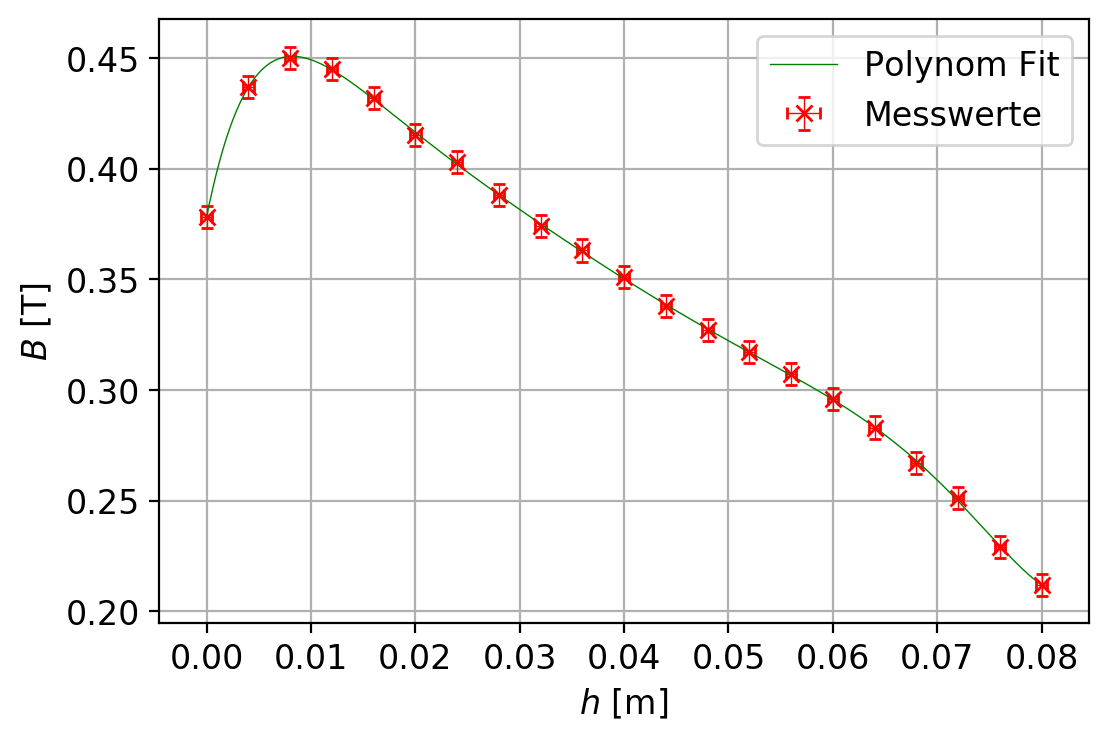

[ 2.32171462e+11  8.62012181e+10 -5.65680648e+10  1.19315474e+10
 -1.40018433e+09  1.02879226e+08 -4.87477566e+06  1.47512472e+05
 -2.70942795e+03  2.34253117e+01  3.78051587e-01]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})



##Magnetfeld ohne Probekörper

offset = 0.011 ##Wert von B ohne Strom in T
h = np.loadtxt("B_none.txt", usecols = 0)/1000 ##Höhe in m
sig_h = 0.5e-3
B = np.loadtxt("B_none.txt", usecols = 1) - offset ##Magentfeld in T
sig_B = 0.005 ##Fehler in T

##Polynomfit
coefficients = np.polyfit(h,B,10)
Bpoly = np.poly1d(coefficients)
new_h = np.linspace(h[0], h[-1],1000)
new_B = Bpoly(new_h)

##plots
plt.figure(dpi = 200)
plt.tight_layout()
plt.xlabel("$h$ [m]")
plt.ylabel("$B$ [T]")
plt.errorbar(h,B,sig_B,sig_h,fmt = 'x',color = 'r',ecolor ='r',linewidth = 0.5,capsize = 2, label = "Messwerte")
plt.plot(new_h,new_B,label = "Polynom Fit",color = 'g',linewidth=0.5)
plt.grid()
plt.legend(loc="upper right")

plt.savefig("B_none.png")
plt.show()

print(coefficients)


In [5]:
##Magnetfeld und Gradient aus Polynomfit
dBdh = np.poly1d.deriv(Bpoly) ##Ableitung von B nach h
sig_Bpoly = sig_h*dBdh  ##Fehlerfortpflanzung B Feld
sig_dBdh = sig_h * np.poly1d.deriv(dBdh) ## Fehlerfortpflanzung Gradient
print(np.poly1d.deriv(dBdh))

h_probe = np.array([61,36.7,57.7])/1000
print(Bpoly(h_probe))
print(sig_Bpoly(h_probe))
print(dBdh(h_probe))
print(sig_dBdh(h_probe))

          8             7             6             5             4
2.09e+13 x + 6.206e+12 x - 3.168e+12 x + 5.011e+11 x - 4.201e+10 x
              3            2
 + 2.058e+09 x - 5.85e+07 x + 8.851e+05 x - 5419
[0.29270812 0.36021161 0.30206411]
[-0.00149619 -0.00154126 -0.00135435]
[-2.99238345 -3.08252303 -2.70870208]
[-0.05719702  0.0141462  -0.02929602]


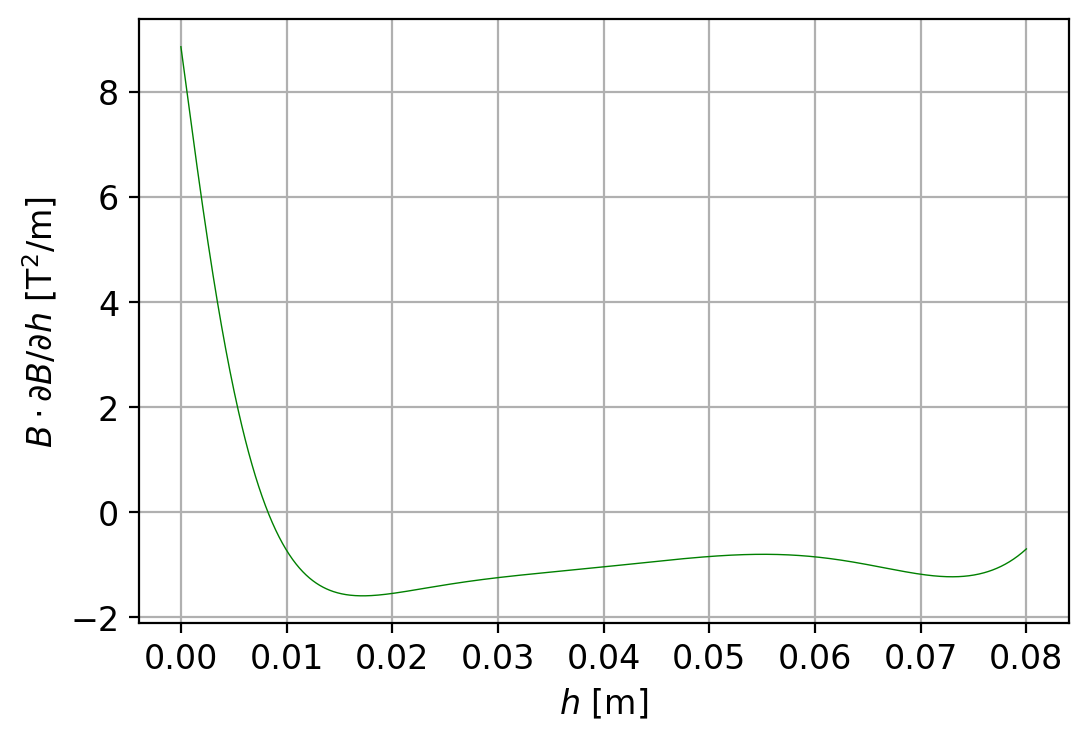

In [6]:
### Produkt aus B und dBdh

plt.figure(dpi = 200)
plt.xlabel("$h$ [m]")
plt.ylabel("$B\cdot\partial B / \partial h$ [T$^2$/m]")
plt.plot(new_h,new_B*dBdh(new_h),color = 'g',linewidth = 0.5,label = "Produkt aus Fit")
plt.grid()
plt.savefig("B_dBdh")
plt.show()

In [7]:
##Kräfte auf die Probekörper
##arrays werden am Ende separiert
g = 9.81
m1 = np.loadtxt("F_probe.txt", usecols = 0)/1000 ##Masse in Kg mit B
m2 = np.loadtxt("F_probe.txt", usecols = 1)/1000 ##Masse in Kg ohne B
dm = m2 - m1
sig_m = 0.0005e-3

F = dm * g
sig_F = sig_m * g

F_mgn = F[0:3]
F_bsmth = F[3:6]
F_tan = F[6:9]

##gewichteter Mittelwert
a = 1/(sig_F**2)*3
F_mgn = (F_mgn[0]/(sig_F**2)+F_mgn[1]/(sig_F**2)+F_mgn[2]/(sig_F**2))/a
F_bs = (F_bsmth[0]/(sig_F**2)+F_bsmth[1]/(sig_F**2)+F_bsmth[2]/(sig_F**2))/a
F_tan = (F_tan[0]/(sig_F**2)+F_tan[1]/(sig_F**2)+F_tan[2]/(sig_F**2))/a
sig_Fmean = np.sqrt(1/a)
dm

array([-9.7e-06, -9.6e-06, -9.4e-06,  5.0e-07,  5.0e-07,  6.0e-07,
       -1.0e-06, -8.0e-07, -1.5e-06])

In [8]:
##Magnetische Suszeptibilität
mu_0 = 1.257e-6
def chi(F,m,grad):
    return mu_0*F/(m*grad)

m_mgn = 0.6429e-3
m_bs = 0.7742e-3
m_tan = 0.8870e-3
chi_mgn = chi(F_mgn,m_mgn,-2.99*0.293) ##spezifische!!
chi_bs = chi(F_bs,m_bs,-3.08*0.360)
chi_tan = chi(F_tan,m_tan,-2.71*0.302)


##Fehlerfortpflanzung
def err(F,m,B,dB,sF,sm,sB,sdB):
    a = sF**2/(m**2*B**2*(dB)**2)
    b = sm**2*F**2/(m**4*B**2*(dB)**2)
    c = sB**2*F**2/(m**2*B**4*(dB)**2)
    d = sdB**2*F**2/(m**2*B**2*(dB)**4)
    return mu_0*np.sqrt(a+b+c+d)


##Fehler
schi_mgn = err(938e-7,m_mgn,0.293,-2.99,29e-7,0.0005e-3,0.002,0.06)
schi_bs = err(52e-7,m_bs,0.36,-3.08,29e-7,0.0005e-3,0.002,0.02)
schi_tan = err(-108e-7,m_tan,0.302,-2.71,29e-7,0.0005e-3,0.002,0.03)


print("Spezifische Suszeptibilität:")
print(chi_mgn,schi_mgn)
print(chi_bs,schi_bs)
print(chi_tan,schi_tan)
print("\n")

##suszeptibilität mal dichte
rho_mgn = 5.03e3
rho_bs = 9.79e3
rho_tan = 16.4e3
print("Suszeptibilität:")
print(chi_mgn*rho_mgn,schi_mgn*rho_mgn)
print(chi_bs*rho_bs,schi_bs*rho_bs)
print(chi_tan*rho_tan,schi_tan*rho_tan)

Spezifische Suszeptibilität:
2.0945112271507157e-07 7.848863556238146e-09
-7.66119697920181e-09 4.246959937023139e-09
1.8685172714483667e-08 5.0273017651088e-09


Suszeptibilität:
0.00105353914725681 3.947978368787788e-05
-7.500311842638572e-05 4.1577737783456526e-05
0.0003064368325175321 8.244774894778432e-05


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in sqrt
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in sqrt


[-2.14     0.34434] [[0.31622777        nan]
 [       nan 0.01941906]]
[-2.71999999  0.42772   ] [[0.31622777        nan]
 [       nan 0.01941906]]
[-3.61999999  0.57462   ] [[0.31622775        nan]
 [       nan 0.01941906]]


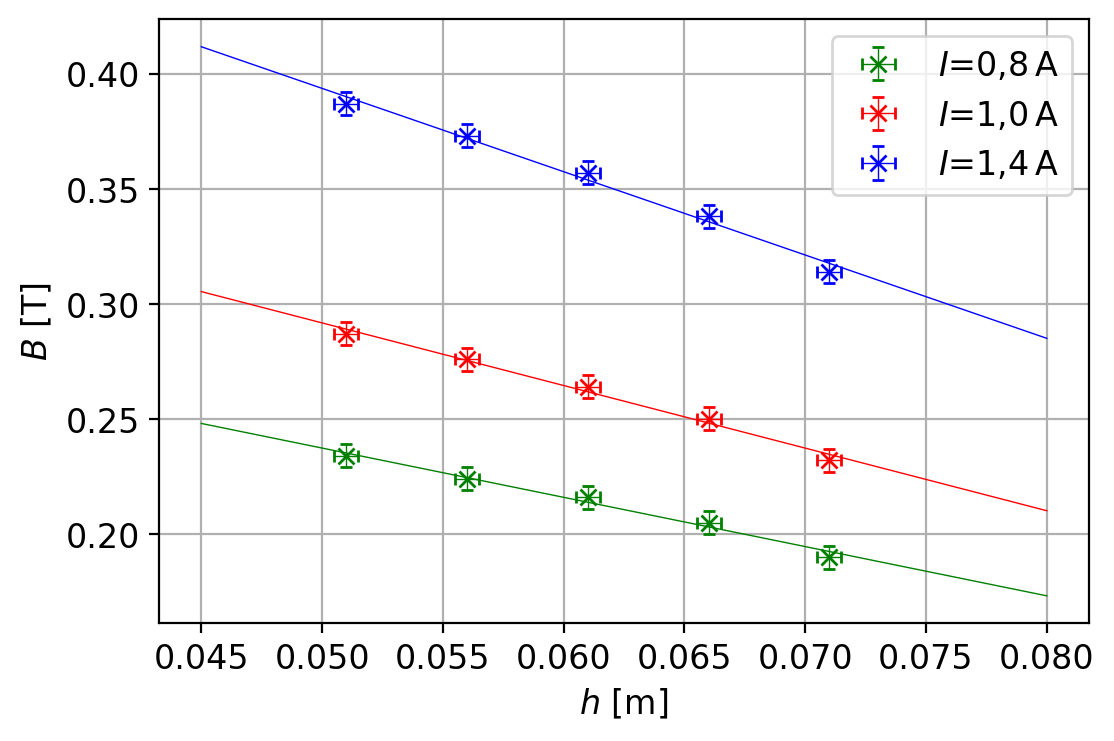

In [11]:

import scipy.optimize

##Gradient bei verschiedenen Stromstärken
h = np.arange(-10,11,5)/1000
h += 61/1000
sig_B = 0.005
sig_h = 0.5e-3


sig_B1 = np.array([0.005,0.005,0.005,0.005,0.005]) ##nur für fit
B08 = np.array([0.234,0.224,0.216,0.205,0.190]) ##0.8A
B10 = np.array([0.287,0.276,0.264,0.250,0.232]) ##1.0A
B12 = np.array([0.387,0.373,0.357,0.338,0.314]) ##1.2A

x = np.linspace(0.045,0.08,1000) ##Werte für fit

def testfunc (x,M,C):##Fitgerade
    return M*x+C

popt08, pcov08 = scipy.optimize.curve_fit(testfunc, h, B08, sigma=sig_B1, p0=[0,0], absolute_sigma=True)
popt10, pcov10 = scipy.optimize.curve_fit(testfunc, h, B10, sigma=sig_B1, p0=[0,0], absolute_sigma=True)
popt12, pcov12 = scipy.optimize.curve_fit(testfunc, h, B12, sigma=sig_B1, p0=[0,0], absolute_sigma=True)

plt.figure(dpi = 200)
#messwerte
plt.errorbar(h,B08,sig_B,sig_h,fmt = 'x',color = 'g',ecolor ='g',linewidth = 0.5,capsize = 2, label = "$I$=0,8$\,$A")
plt.errorbar(h,B10,sig_B,sig_h,fmt = 'x',color = 'r',ecolor ='r',linewidth = 0.5,capsize = 2, label = "$I$=1,0$\,$A")
plt.errorbar(h,B12,sig_B,sig_h,fmt = 'x',color = 'b',ecolor ='b',linewidth = 0.5,capsize = 2, label = "$I$=1,4$\,$A")
##fits
plt.plot(x,testfunc(x,popt08[0],popt08[1]),color = 'g',linewidth = 0.5)
plt.plot(x,testfunc(x,popt10[0],popt10[1]),color = 'r',linewidth = 0.5)
plt.plot(x,testfunc(x,popt12[0],popt12[1]),color = 'b',linewidth = 0.5)

plt.legend(loc="upper right")
plt.xlabel("$h$ [m]")
plt.ylabel("$B$ [T]")
plt.grid()
plt.savefig("B_varI.png")

print(popt08,np.sqrt(pcov08))
print(popt10,np.sqrt(pcov10))
print(popt12,np.sqrt(pcov12))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


[-2.45378785 -0.1777273 ] [[0.04605663        nan]
 [       nan 0.05063238]]


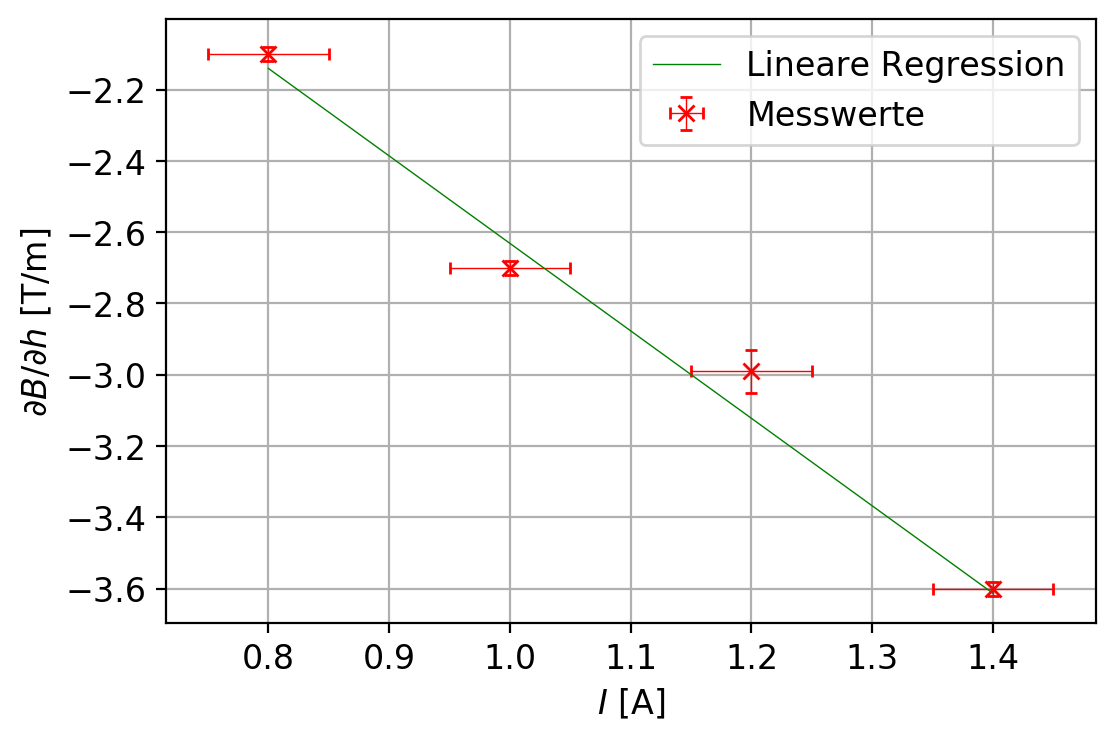

In [12]:
##Gradient der magnetischen Flussdichte in Abhängigkeit von I
dBdh = np.array([-2.1,-2.7,-2.99,-3.6])
sdBdh = np.array([0.02,0.02,0.06,0.02])##Fehler
I = np.array([0.8,1,1.2,1.4])
x = np.linspace(0.8,1.4,1000)
#fit
popt, pcov = scipy.optimize.curve_fit(testfunc, I, dBdh, sigma=sdBdh, p0=[0,0], absolute_sigma=True)


plt.figure(dpi = 200)
#messwerte
plt.errorbar(I,dBdh,sdBdh,0.05,fmt = 'x',color = 'r',ecolor ='r',linewidth = 0.5,capsize = 2,label = "Messwerte")
#fit
plt.plot(x,testfunc(x,popt[0],popt[1]),color = 'g',linewidth = 0.5,label = "Lineare Regression")
plt.xlabel("$I$ [A]")
plt.ylabel("$\partial B/\partial h$ [T/m]")
plt.legend(loc="upper right")
plt.grid()
plt.legend(loc="upper right")
plt.savefig("dBdh_I.png")

print(popt,np.sqrt(pcov))






/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in sqrt


[0.2338913  0.02916522] [[0.00115392        nan]
 [       nan 0.00126663]]


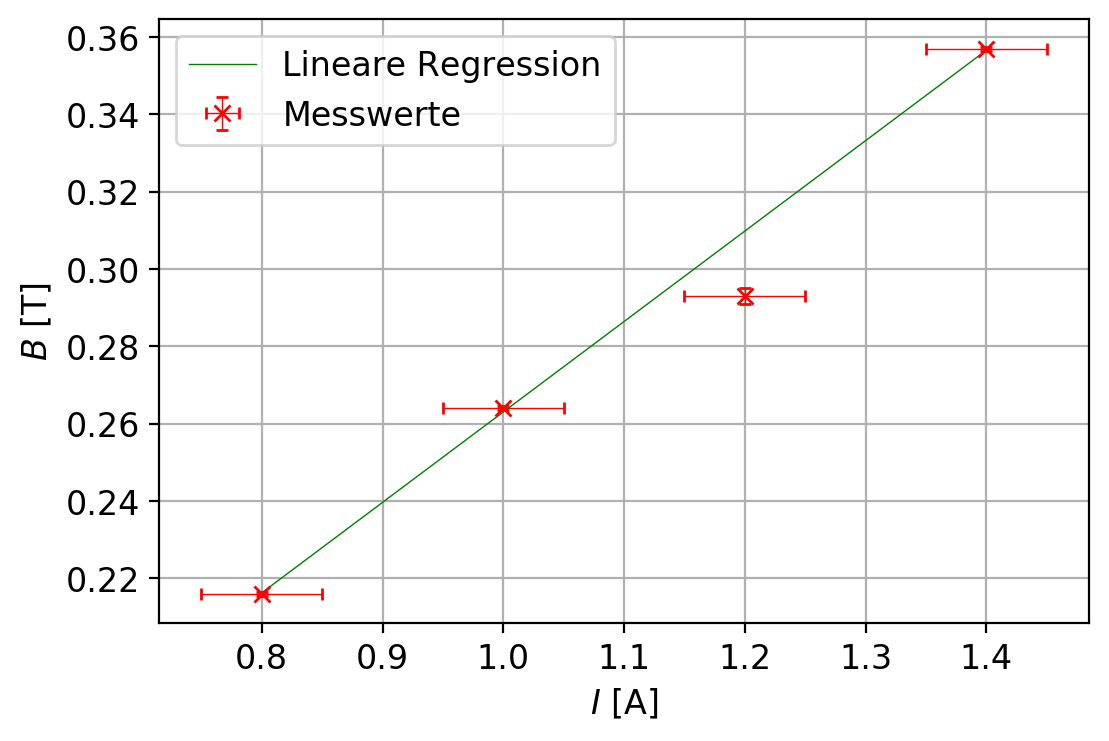

In [13]:
##Magnetfeld gegen Strom(nur Mangandioxid)
B = np.array([0.216,0.264,0.293,0.357])
sig_B = np.array([0.0005,0.0005,0.002,0.0005])


popt, pcov = scipy.optimize.curve_fit(testfunc, I, B, sigma=sig_B, p0=[0,0], absolute_sigma=True)


plt.figure(dpi = 200)
plt.errorbar(I,B,sig_B,0.05,fmt = 'x',color = 'r',ecolor ='r',linewidth = 0.5,capsize = 2,label = "Messwerte")
plt.plot(x,testfunc(x,popt[0],popt[1]),color = 'g',linewidth = 0.5,label = "Lineare Regression")
plt.xlabel("$I$ [A]")
plt.ylabel("$B$ [T]")
plt.grid()
plt.legend(loc="upper left")
plt.savefig("B_I.png")

print(popt,np.sqrt(pcov))

-4.218299999999943e-05 -6.0494999999999515e-05 -0.0001294919999999996 2.831903070375114e-06
[-1.47450000e-04  8.06699999e-05] [[6.48459723e-06            nan]
 [           nan 7.27894233e-06]]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in sqrt


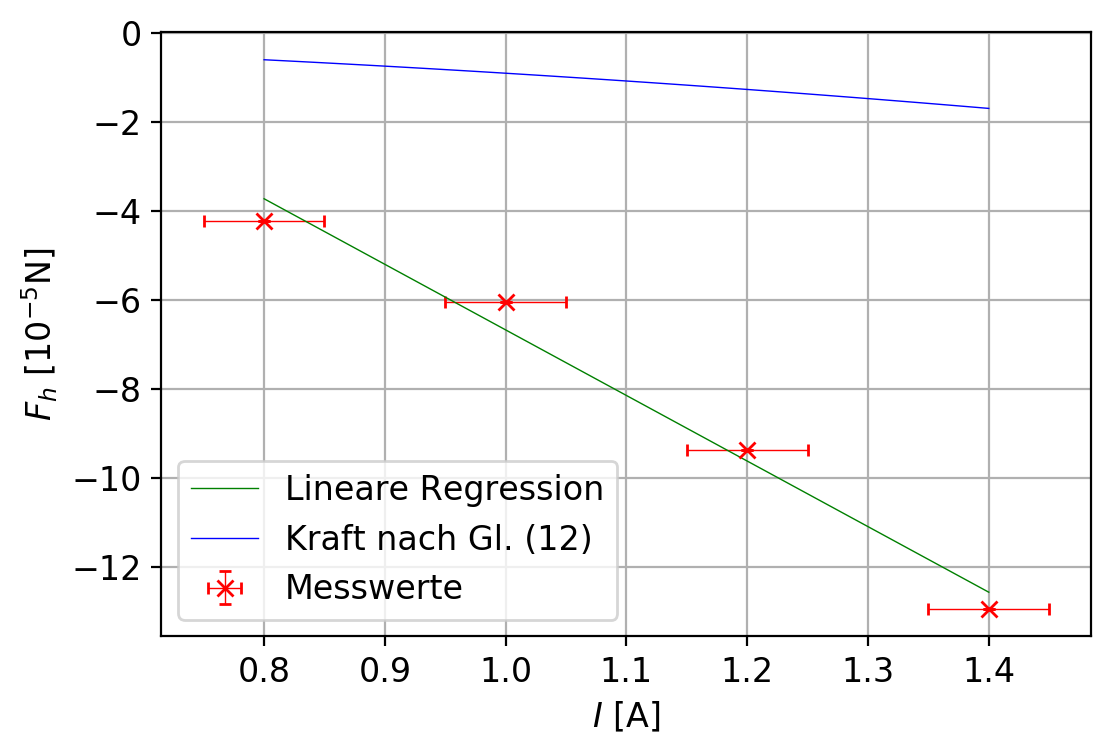

In [14]:
### Kraft in Abhängigkeit der Stromstärke
g = 9.81
sig_m = 0.0005e-3
m1 = 0.6429/1000 ## Masse ohne B
m2 = np.array([0.6469,0.6472,0.6475,0.6484,0.6490,0.6498,0.6559,0.6564,0.6560])/1000 ##Masse mit B
dm = m1 - m2
F = dm*g
sig_F = sig_m * g
I = np.array([0.8,1,1.2,1.4])


F08 = F[0:3]
F10 = F[3:6]
F14 = F[6:9]

##gewichteter Mittelwert
a = 1/(sig_F**2)*3
F08 = (F08[0]/(sig_F**2)+F08[1]/(sig_F**2)+F08[2]/(sig_F**2))/a
F10 = (F10[0]/(sig_F**2)+F10[1]/(sig_F**2)+F10[2]/(sig_F**2))/a
F14 = (F14[0]/(sig_F**2)+F14[1]/(sig_F**2)+F14[2]/(sig_F**2))/a
sig_Fmean = np.sqrt(1/a)

print(F08,F10,F14,sig_Fmean)

##signifikant gerundet, nur Mangandioxid (inkl Wert für 1,2A)
F = np.array([-423,-605,-938,-1295])*1e-7
sig_F = np.array([29e-7,29e-7,29e-7,29e-7])

popt, pcov = scipy.optimize.curve_fit(testfunc, I, F, sigma=sig_F, p0=[0,0], absolute_sigma=True)

plt.figure(dpi = 200)
plt.errorbar(I,F*100000,sig_F,0.05,fmt = 'x',color = 'r',ecolor ='r',linewidth = 0.5,capsize = 2,label = "Messwerte")
plt.xlabel("$I$ [A]")
plt.ylabel("$F_h$ [$10^{-5}$N]")
plt.plot(x,testfunc(x,popt[0],popt[1])*100000,color = 'g',linewidth = 0.5,label = "Lineare Regression")
plt.grid()

chi = 13.2e-5 ##Messwert Mangandioxid
m = 0.6429e-3
rho = 5030
mu_0 = 1.257e-6

def F(I):
    return m*chi/(rho*mu_0)*(2339e-4*I+229e-4)*(-245e-2*I-18e-2)

I = np.linspace(0.8,1.4,100)
plt.plot(I,F(I)*100000,color = 'b', linewidth = 0.5,label = "Kraft nach Gl. (12)")

plt.legend(loc="lower left")

plt.savefig("F_I.png")

print(popt,np.sqrt(pcov))